In [47]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import style
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import os
style.use('ggplot')

### Prepare Dataset

In [14]:

my_word = ENGLISH_STOP_WORDS 

POS_TRAIN_PATH = './dataset/aclImdb/train/pos/'
NEG_TRAIN_PATH = './dataset/aclImdb/train/neg/'
pos_files = os.listdir(POS_TRAIN_PATH)
neg_files = os.listdir(NEG_TRAIN_PATH)
print('Docs prep....')

pos_lines = []
neg_lines = []
for file in pos_files:
    with open(POS_TRAIN_PATH + file) as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines if line.strip()]
        pos_lines.extend(lines)
for file in neg_files:
    with open(NEG_TRAIN_PATH + file) as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines if line.strip()]
        neg_lines.extend(lines)

docs = []
docs.extend(pos_lines)
docs.extend(neg_lines)
print('Vectorize...')
vectorizer2 = TfidfVectorizer(stop_words=my_word, max_features=250)
vectorizer2.fit(docs)
print('Vectorization done')

input_data2 = vectorizer2.transform(docs).todense()
print(input_data2.shape)
df2 = pd.DataFrame(input_data2)

pos_labels = np.zeros(len(pos_lines))
neg_labels = np.ones(len(neg_lines))

labels2 = []
labels2 = np.append(pos_labels, neg_labels)
df2['labels'] = labels2
# df2.to_csv('data/aclImdb/processed_input_labelled3.csv')

pos_labels = np.zeros(len(pos_lines))
neg_labels = np.ones(len(neg_lines))

X = df2.drop('labels', axis=1)
X = np.array(X)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, df2['labels'], random_state=20)




Docs prep....
Vectorize...
Vectorization done
(25000, 250)
(25000, 250)


### Save Vectorizer

In [53]:
from sklearn.externals import joblib
joblib.dump(vectorizer2, './models/vectorizer.pkl')

['./models/vectorizer.pkl']

### Create NN

In [15]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.ln0 = nn.Linear(input_size, 15)
        self.ln1 = nn.Linear(15, output_size)
        

    def forward(self, x):
        output = F.relu(self.ln0(x))
        output = F.tanh(self.ln1(output))
        return output
print(SimpleNN(X_train.shape[1],2))


SimpleNN (
  (ln0): Linear (250 -> 15)
  (ln1): Linear (15 -> 2)
)


### Train and Evaluate

SimpleNN (
  (ln0): Linear (250 -> 15)
  (ln1): Linear (15 -> 2)
)
Epoch 0 loss 0.7000580430030823
Test acc: 0.56368
Epoch 10 loss 0.5386714935302734
Test acc: 0.74464
Epoch 20 loss 0.47444796562194824
Test acc: 0.79376
Epoch 30 loss 0.45913681387901306
Test acc: 0.79456
Epoch 40 loss 0.4506608843803406
Test acc: 0.79984


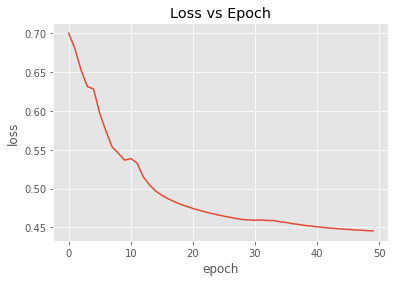

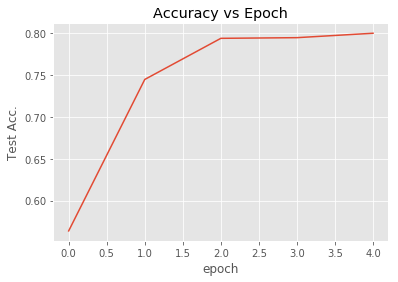

Final Test accuracy 0.804


In [36]:
net = SimpleNN(X_train.shape[1], 2)
print(net)

def evaluate(X_test,y_test):
    total = len(X_test)
    correct = 0.0
    net.eval()

    for val_x, val_y in zip(X_test, y_test):

        t_x = np.array(val_x).astype(np.float32)
        output = net(Variable(torch.from_numpy(np.array([t_x]))))[0]

        out = output.data.numpy()
        if val_y == 0:

            if not np.argmax(out):
                correct += 1


        if val_y == 1:

            if np.argmax(out):
                correct += 1

#     print('Test accuracy %.3f' % (correct / total))
    return correct / total

epochs = 50
learning_rate = 5e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(net.parameters(), lr=learning_rate)
losses = []
acc = []
epoch_ = []
for epoch in range(epochs):
    net.train()
    inputs = Variable(torch.from_numpy(np.array(X_train).astype(np.float32)))
    targets = Variable(torch.from_numpy(np.array(y_train).astype(np.float32)).long())
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    
        
    if epoch % 10 == 0:
        print('Epoch %d loss %s' % (epoch, loss.data[0]))
        test_acc = evaluate(X_test, y_test)
        acc.append(test_acc)
        print('Test acc:', test_acc)

    losses.append(loss.data[0])

plt.title('Loss vs Epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(losses)
plt.show()

plt.title('Accuracy vs Epoch')
plt.xlabel('epoch')
plt.ylabel('Test Acc.')
plt.plot(acc)
plt.show()

print('Final Test accuracy %.3f' % evaluate(X_test, y_test))



### SAVE MODEL

In [39]:
MODELS_DIR = './models'
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)
torch.save(net.state_dict(), MODELS_DIR + '/sentiment.pt')

### Load Model

In [55]:
vectorizer = joblib.load('./models/vectorizer.pkl')

In [48]:
model = SimpleNN(250, 2)
model.load_state_dict(torch.load('./models/sentiment.pth'))

In [80]:

def test_line(line, vectorizer, model):
    
    t_x = vectorizer.transform([line]).todense().astype(np.float32)

    t_x = np.array([t_x]).reshape(1,-1)

    model.eval()
    out = model(Variable(torch.from_numpy(t_x)))
    val = out.data.numpy()

    
    if not np.argmax(val):
        return 'Positive'
    elif np.argmax(val):
        return 'Negative'
    
print(test_line('Gov to create new policies for the betterment of farmers', vectorizer, model))
print(test_line('2 people killed in plane crash',vectorizer, model))

Positive
Negative


In [69]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import pandas as pd


In [70]:
class Crawler(object):
    
    def __init__(self, url:str,path_to_save:str):
        self.url = url
        self.bsObj = None
        self.links = None
        self.path  = path_to_save + '.txt'
    
    def crawl(self)->list:
        self.bsObj = BeautifulSoup(urlopen(self.url), 'html.parser')
        links = []
        for value in self.bsObj.find_all('div', {'class':'media-body'}):

            links.append((value.find('span',{"class":"time-dt"}).text,value.find('a').attrs['href'],value.find('a').text))
        self.links = links
        return self.links
    
    def save(self)->None:
        if self.path:
            if self.links:
                df = pd.DataFrame(self.links)
                df.to_csv(self.path)
            else:
                print('Crawl before save')
        else:
            print('Select path to save')
    
    def get_article(self, link:str, path:str):
        self.bsObj = BeautifulSoup(urlopen(link))
        


In [95]:

CITIES = ['delhi-news','kolkata', 'mumbai', 'pune-news', 'lucknow', 'mumbai-news']
url = 'http://www.hindustantimes.com/'
if not os.path.exists('./links'):
    os.makedirs('./links/')
ARTICLE_DIR = './articles/'
data = []
for city  in CITIES:
    query_url = url+city
    crawler = Crawler(query_url,'./links/'+city)
    links = crawler.crawl()
    print('Crawling articles of '+ city + '.....')
#     print(links)

    for link in links:
#         print('*'*10)
#         print(link)
        bsobj = BeautifulSoup(urlopen(link[1]),'html.parser')
#         para = bsobj.find('div',{"class": "story-details"}).find_all('p')
        para = bsobj.find_all('p')
        para_text = ''
        for text in para:
            para_text += text.text
        if not os.path.exists('articles'):
            os.makedirs(ARTICLE_DIR)
        
        with open(ARTICLE_DIR+city+'.txt', 'a') as f:
            f.writelines(para_text)
            f.write('\n*****\n')
    


Crawling articles of delhi-news.....
Crawling articles of kolkata.....
Crawling articles of mumbai.....
Crawling articles of pune-news.....
Crawling articles of lucknow.....
Crawling articles of mumbai-news.....


In [96]:
for city  in CITIES:
    query_url = url+city
    crawler = Crawler(query_url,'./links/'+city)
    links = crawler.crawl()
    print('Crawling articles of '+ city + '.....')
    print(len(links))
    crawler.save()

Crawling articles of delhi-news.....
48
Crawling articles of kolkata.....
48
Crawling articles of mumbai.....
48
Crawling articles of pune-news.....
48
Crawling articles of lucknow.....
48
Crawling articles of mumbai-news.....
48
